# Notebook 3 - Testing DoMINO Model on the Ahmed body surface dataset

In this notebook, we will first provide a detailed explanation of the DoMINO architecture, which is a multi-scale, iterative neural operator designed for modeling large-scale engineering simulations. We will break down the key components of DoMINO, including its use of local geometry representations, multi-scale point convolution kernels, and its efficient handling of complex geometries. Afterward, we will train the model using the **Ahmed body surface dataset**, a widely used dataset in automotive aerodynamics simulations. *As indicated in the previous notebook this dataset was created by the NVIDIA Physics NeMo development team and differs from other similar datasets hosted on cloud platforms like AWS.* 

The DoMINO model is capable of training both volume fields (such as velocity and pressure) and surface fields (including pressure and wall shear stress). However, for the sake of simplicity and educational purposes, this notebook will *focus solely on training the surface fields* using the Ahmed body surface dataset.
*

## Table of Contents
- [Load Model Checkpoint & Run Inference](#Load-Model-Checkpoint-&-Run-Inference)
- [Visualizing the predicted results](#Visualizing-the-predicted-results)


In [48]:
import time
import os
import re
import torch
import torchinfo


import pyvista as pv
from tqdm import tqdm
from pathlib import Path
from types import SimpleNamespace
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import hydra
from hydra.utils import to_absolute_path
from omegaconf import DictConfig, OmegaConf

from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

from physicsnemo.distributed import DistributedManager
from physicsnemo.launch.utils import load_checkpoint, save_checkpoint
from physicsnemo.utils.sdf import signed_distance_field

from physicsnemo.datapipes.cae.domino_datapipe import DoMINODataPipe
from physicsnemo.models.domino.model import DoMINO
from physicsnemo.utils.domino.utils import *

In [49]:
# Directory and Path Configuration
EXPERIMENT_TAG = 4  # Unique identifier for this experiment run
PROJECT_NAME = "ahmed_body_dataset"  # Name of the project
OUTPUT_DIR = Path(
    f"./outputs/{PROJECT_NAME}/{EXPERIMENT_TAG}"
)  # Directory for experiment outputs
DATA_DIR = Path("./ahmed_body_dataset/")  # Root directory for dataset
PROCESSED_DIR = (
    DATA_DIR / "prepared_surface_data"
)  # Directory for processed surface data
CHECKPOINT_DIR = OUTPUT_DIR / "models"  # Directory for saving model checkpoints
SAVE_PATH = DATA_DIR / "mesh_predictions_surf_final1"  # path to save prediction results

# Ensure directories exist
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Physical Variables
VOLUME_VARS = ["p"]  # Volume variables to predict (pressure)
SURFACE_VARS = ["p", "wallShearStress"]  # Surface variables to predict
MODEL_TYPE = "surface"  # Type of model (surface-only prediction)
AIR_DENSITY = 1.205  # Air density in kg/m³
STREAM_VELOCITY = 60

# Training Hyperparameters
NUM_EPOCHS = 3  # Number of training epochs
LR = 0.001  # Learning rate
BATCH_SIZE = 1  # Batch size for training
GRID_RESOLUTION = [128, 64, 48]  # Resolution of the interpolation grid
NUM_SURFACE_NEIGHBORS = 7  # Number of neighbors for surface operations
NORMALIZATION = "min_max_scaling"  # Data normalization method
INTEGRAL_LOSS_SCALING = 0  # Scaling factor for integral loss
NUM_SURF_VARS = 4  # Number of surface variables to predict, 3 for vectore (wallShearStress) and 1 for scalar (p)
CHECKPOINT_INTERVAL = 1  # Save checkpoint every N epochs

# Dataset Paths
DATA_PATHS = {
    "train": "./ahmed_body_dataset/train_prepared_surface_data",
    "val": "./ahmed_body_dataset/validation_prepared_surface_data",
    "test": "./ahmed_body_dataset/test",
}

# Model and Scaling Factor Paths
MODEL_SAVE_DIR = "./outputs/ahmed_body_dataset/4/models"
SURF_SAVE_PATH = "./outputs/ahmed_body_dataset/surface_scaling_factors.npy"

# Bounding Box Configuration for Volume and Surface Meshes
BOUNDING_BOX = SimpleNamespace(
    max=[0.5, 0.6, 0.6],  # Maximum coordinates for volume mesh
    min=[-2.5, -0.5, -0.5],  # Minimum coordinates for volume mesh
)
BOUNDING_BOX_SURF = SimpleNamespace(
    max=[0.01, 0.6, 0.4],  # Maximum coordinates for surface mesh
    min=[-1.5, -0.01, -0.01],  # Minimum coordinates for surface mesh
)

# Set cuDNN benchmark mode
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

## **Load Model Checkpoint & Run Inference**

The sixth step in our workflow focuses on evaluating our trained DoMINO model by loading the best checkpoint and running inference on sample cases. 
To run the inference, the script needs several key **inputs**. It requires the 3D shape of the object defined in an STL file and a corresponding surface mesh provided as a VTP file, which also contain results from a traditional simulation for comparison purposes. 
Crucially, it needs the pre-trained DoMINO AI model loaded from a checkpoint file. Additionally, basic flow conditions like air speed (`STREAM_VELOCITY`) and density (`AIR_DENSITY`), along with specific scaling factors saved from the training phase (used to convert model outputs to physical values), must be provided.


As its main **output**, the script generates new VTP files for each tested geometry. These files include the original surface mesh data but are augmented with new data fields representing the AI model's predictions for aerodynamic quantities such as surface pressure and wall shear stress. Furthermore, the script calculates aerodynamic forces based on these predictions and prints a comparison against forces derived from reference data directly to the console.
The code snippet below takes geometry files (STL) and corresponding simulation setup data (partially from VTP files and config parameters), preprocesses them, feeds them into the model to predict aerodynamic quantities (like surface pressure and shear stress), and saves these predictions back into VTP files for analysis and visualization.

#### Understanding the Testing Process

The testing process involves several key components:
1. Loading the best model checkpoint
2. Preparing test data
3. Running inference on test cases
4. Analyzing prediction results
5. Comparing with ground truth values

#### Key Components and Libraries

We'll use the following libraries for testing:

1. **PyTorch**
   - `torch.load()`: For loading model checkpoints
   - `model.load_state_dict()`: For restoring model weights
   - `torch.no_grad()`: For efficient inference

2. **Custom Testing Functions**
   - `test_step()`: For running inference on test cases
   - Data processing utilities for test data preparation

#### Implementation Overview

The testing is implemented through several key components:

1. **Function test_step**
    Within the **test_step** function, several key operations execute in sequence. Initially, torch.no_grad() is used to disable gradient tracking in PyTorch, optimizing performance by saving memory and computation time as gradients are unnecessary during inference. 
Next, the necessary data is prepared by extracting inputs like air density, stream velocity, geometry coordinates, bounding box grid information (surf_grid), and the Signed Distance Field (SDF) from the data_dict; the SDF is particularly important as it helps the model understand the position of points relative to the geometry surface. 
Following this, a global geometry encoding is generated using model.geo_rep, which takes normalized geometry points, the grid, and the SDF to create a comprehensive representation of the overall shape. 
Surface-specific data, including mesh points, normals, areas, and neighbor details (found via methods like KDTree during preprocessing), are then extracted. 
To refine the focus, model.geo_encoding_local_surface extracts relevant local geometric features from the global encoding specifically for the surface points where predictions are needed. 
Positional awareness is added using model.position_encoder to encode the relative location of surface points. 
The core prediction then occurs via model.calculate_solution_with_neighbors, combining local geometry, positional encoding, surface point details, neighbor information, and flow conditions to estimate the target surface fields like pressure coefficient or wall shear stress. Since the model output is normalized, a final un-normalization step converts these predictions back into physical units using the provided surf_factors, stream velocity, and air density. The function concludes by returning the predicted surface fields (prediction_surf), as this specific code path concentrates only on surface predictions.



```python
def test_step(model, data_dict, surf_factors, device):
    """
    Executes the core inference logic for a single test case using the trained DoMINO model.
    
    Args:
        model (DoMINO): The trained model
        data_dict: A dictionary containing all necessary input data for this specific test case (geometry, mesh points, flow conditions, etc.), already preprocessed and formatted.
        surf_factors: Scaling factors used during training to normalize the target surface data. Needed here to un-normalize the model's predictions back to physical values.
        device: The computational device (CPU or GPU) to run the calculations on.
        
    Returns:
        tuple: (prediction_vol, prediction_surf) - Model predictions for volume and surface
    """
```


2. **Function: test**
```python
def test(model, test_dataloader, device):
    """
    Run testing on the model using the provided test dataloader.
    
    Args:
        model (DoMINO): The trained model
        test_dataloader (DataLoader): DataLoader containing test data
        device (torch.device): Device to run inference on
        
    Returns:
        list: List of tuples containing (prediction_vol, prediction_surf) for each test case
    """
```

On the other hand, the test function is a higher-level function that organizes and controls the overall testing process. It begins by checking if surface scaling factors have been pre-computed and stored in a .npy file. If the file exists, it loads these factors; if not, it defaults to None. The function then loads a pre-trained model from a checkpoint file (DoMINO.0.....pt) and loads its state into the model. After the model is loaded, it creates a directory for saving predictions if it doesn't already exist. The dirname parameter is used to extract a tag, which helps identify the current test case.

Next, the function proceeds to load the necessary input files. It reads an STL file that contains the 3D geometry of the surface and extracts relevant data like vertices, faces, and areas. The bounding box dimensions are calculated, and the surface’s center of mass is computed. Then, it prepares a grid (surf_grid) and calculates the signed distance function (SDF) over this grid using the surface geometry, which helps in understanding the geometry’s proximity to the grid points. The function then reads the VTP file, which holds additional surface-related data such as pressure and shear force values.

The surface fields are then prepared by interpolating the surface mesh data and its corresponding attributes. These fields are normalized to fit within the bounding box dimensions. The data dictionary is assembled, containing all the relevant inputs needed for the model’s prediction. This dictionary includes things like normalized surface coordinates, surface areas, and field values such as stream velocity and air density. The dictionary is converted to PyTorch tensors, making it compatible with the model.

The test_step function is then called with this prepared data to compute the model's predictions. After the predictions are generated, the function compares the predicted surface forces (pressure and shear stress) with the true values from the surface fields. It calculates the predicted forces and prints out the comparison between the predicted and true values. The predicted surface fields are then converted to VTK format and saved to a file. Finally, the function finishes by returning, completing the testing process. This function provides a complete pipeline for testing a trained model on surface data, generating predictions, and saving them for further analysis.


Let's proceed with loading our trained model and running the tests:

In [50]:
def setup_distributed():
    """
    Initialize distributed training environment.

    Returns:
        tuple: (device, rank, world_size)
            - device: torch.device for computation
            - rank: process rank in distributed setup
            - world_size: total number of processes
    """
    rank = int(os.environ.get("RANK", 0))
    world_size = int(os.environ.get("WORLD_SIZE", 1))
    local_rank = int(os.environ.get("LOCAL_RANK", 0))

    # Set up CUDA device
    torch.cuda.set_device(local_rank)
    print("torch.cuda.set_device(local_rank)", torch.cuda.set_device(local_rank))
    print("rank:::", rank)
    print("world_size, local_rank", world_size, local_rank)
    device = torch.device(f"cuda:{local_rank}")

    # Initialize distributed process group if needed
    if world_size > 1:
        torch.distributed.init_process_group(backend="nccl", init_method="env://")

    return device, rank, world_size


def create_model(device, rank, world_size):
    """
    Create and configure DoMINO model with distributed training support.

    Args:
        device (torch.device): Computation device
        rank (int): Process rank
        world_size (int): Total number of processes

    Returns:
        DoMINO: Configured model (wrapped in DistributedDataParallel if world_size > 1)
    """

    # Initialize model with configuration
    model = DoMINO(
        input_features=3,
        output_features_vol=None,
        output_features_surf=NUM_SURF_VARS,
        model_parameters=SimpleNamespace(
            interp_res=GRID_RESOLUTION,
            surface_neighbors=NUM_SURFACE_NEIGHBORS,
            use_surface_normals=True,
            use_only_normals=True,
            encode_parameters=True,
            positional_encoding=False,
            integral_loss_scaling_factor=INTEGRAL_LOSS_SCALING,
            normalization=NORMALIZATION,
            use_sdf_in_basis_func=True,
            geometry_rep=SimpleNamespace(
                base_filters=16,
                geo_conv=SimpleNamespace(
                    base_neurons=32,
                    base_neurons_out=1,
                    radius_short=0.1,
                    radius_long=0.5,
                    hops=1,
                ),
                geo_processor=SimpleNamespace(base_filters=8),
                geo_processor_sdf=SimpleNamespace(base_filters=8),
            ),
            nn_basis_functions=SimpleNamespace(base_layer=512),
            parameter_model=SimpleNamespace(
                base_layer=512, scaling_params=[60.0, 1.226]
            ),
            position_encoder=SimpleNamespace(base_neurons=512),
            geometry_local=SimpleNamespace(
                neighbors_in_radius=64, radius=0.05, base_layer=512
            ),
            aggregation_model=SimpleNamespace(base_layer=512),
            model_type=MODEL_TYPE,
        ),
    ).to(device)

    # Wrap model for distributed training if needed
    if world_size > 1:
        model = DistributedDataParallel(
            model, device_ids=[rank], output_device=rank, find_unused_parameters=True
        )
    return model

In [51]:
def test_step(model, data_dict, surf_factors, device):
    """
    Run a single test step on the model.

    Args:
        model (DoMINO): The trained model
        data_dict (dict): Dictionary containing test data
        device (torch.device): Device to run inference on

    Returns:
        tuple: (prediction_vol, prediction_surf) - Model predictions for volume and surface
    """

    avg_tloss_vol = 0.0  # Placeholder for average volume loss (not currently used)
    avg_tloss_surf = 0.0  # Placeholder for average surface loss (not currently used)

    with (
        torch.no_grad()
    ):  # Disable gradient computation to save memory and computation during inference
        # Move input data to the specified device (CPU or GPU)
        data_dict = dict_to_device(data_dict, device)

        # Extract non-dimensionalization factors (important for scaling the inputs)
        air_density = data_dict["air_density"]
        stream_velocity = data_dict["stream_velocity"]
        length_scale = data_dict["length_scale"]

        # Extract geometry coordinates (nodes of the surface)
        geo_centers = data_dict["geometry_coordinates"]

        # Extract bounding box grid and signed distance function (SDF) grid for the surface
        s_grid = data_dict["surf_grid"]
        sdf_surf_grid = data_dict["sdf_surf_grid"]

        # Extract scaling factors for surface (used for un-normalization)
        surf_max = data_dict["surface_min_max"][:, 1]
        surf_min = data_dict["surface_min_max"][:, 0]

        # Normalize geometry coordinates to fit within a bounding box [-1, 1]
        geo_centers_surf = 2.0 * (geo_centers - surf_min) / (surf_max - surf_min) - 1

        # Generate geometric representation of the surface
        encoding_g_surf = model.geo_rep(geo_centers_surf, s_grid, sdf_surf_grid)

        prediction_vol = None  # Volume prediction is not computed in this function

        # Extract information about the surface: mesh centers, normals, areas, and neighbors
        surface_mesh_centers = data_dict["surface_mesh_centers"]
        surface_normals = data_dict["surface_normals"]
        surface_areas = data_dict["surface_areas"]

        surface_mesh_neighbors = data_dict["surface_mesh_neighbors"]
        surface_neighbors_normals = data_dict["surface_neighbors_normals"]
        surface_neighbors_areas = data_dict["surface_neighbors_areas"]

        surface_areas = torch.unsqueeze(surface_areas, -1)  # Add extra dimension
        surface_neighbors_areas = torch.unsqueeze(
            surface_neighbors_areas, -1
        )  # Add extra dimension
        pos_surface_center_of_mass = data_dict["pos_surface_center_of_mass"]
        num_points = surface_mesh_centers.shape[1]  # Number of surface points

        # Extract target surface fields (for comparison later)
        target_surf = data_dict["surface_fields"]
        prediction_surf = np.zeros_like(
            target_surf.cpu().numpy()
        )  # Initialize prediction array

        start_time = time.time()  # Record the start time for performance measurement

        # Generate local geometric encoding for each surface point
        geo_encoding_local = model.geo_encoding_local_surface(
            0.5 * encoding_g_surf, surface_mesh_centers, s_grid
        )

        # Position encoding based on the center of mass of the surface
        pos_encoding = pos_surface_center_of_mass
        pos_encoding = model.position_encoder(pos_encoding, eval_mode="surface")

        # Perform the model prediction using neighbors and other surface data
        tpredictions = model.calculate_solution_with_neighbors(
            surface_mesh_centers,
            geo_encoding_local,
            pos_encoding,
            surface_mesh_neighbors,
            surface_normals,
            surface_neighbors_normals,
            surface_areas,
            surface_neighbors_areas,
            stream_velocity,
            air_density,
        )

        # Convert model predictions to numpy arrays for further processing
        prediction_surf = tpredictions.cpu().numpy()

        # Unnormalize the surface predictions and scale them using physical quantities
        prediction_surf = (
            unnormalize(prediction_surf, surf_factors[0], surf_factors[1])
            * stream_velocity[0, 0].cpu().numpy() ** 2.0
            * air_density[0, 0].cpu().numpy()
        )

    return prediction_vol, prediction_surf  # Return volume and surface predictions


def test(filepath, dirname, model):
    """
    High-level function to manage the testing pipeline, including data preparation, model loading, and prediction saving.

    Args:
        filepath (str): Path to the test data directory
        dirname (str): Directory name for the test case

    Returns:
        None
    """
    # Define names of surface variables to be predicted
    surface_variable_names = SURFACE_VARS

    # Check if surface scaling factors are available
    surf_save_path = os.path.join(
        "outputs", PROJECT_NAME, "surface_scaling_factors.npy"
    )
    if os.path.exists(surf_save_path):
        surf_factors = np.load(surf_save_path)  # Load scaling factors if available
    else:
        surf_factors = None  # If not available, set to None

    # Set the path to save predictions
    pred_save_path = SAVE_PATH
    create_directory(pred_save_path)  # Create the output directory if it doesn't exist

    # Extract test case identifier from the directory name
    tag = int(re.findall(r"(\w+?)(\d+)", dirname)[0][1])
    vtp_path = filepath  # Path to the VTP file with surface data

    # Prepare the path to save predicted results
    vtp_pred_save_path = os.path.join(pred_save_path, f"boundary_{tag}_predicted.vtp")

    # Load the STL file for the geometry
    path_stl = Path(filepath)
    test_file_path = os.path.join(DATA_DIR, "test_stl_files")
    stl_path = os.path.join(test_file_path, path_stl.stem + ".stl")
    print("stl_path::", stl_path)
    print("filepath::", filepath)

    # Read and process the STL file
    reader = pv.get_reader(stl_path)
    mesh_stl = reader.read()
    stl_vertices = mesh_stl.points
    stl_faces = np.array(mesh_stl.faces).reshape((-1, 4))[
        :, 1:
    ]  # Extract triangular faces
    mesh_indices_flattened = stl_faces.flatten()
    length_scale = np.amax(
        np.amax(stl_vertices, 0) - np.amin(stl_vertices, 0)
    )  # Compute scale of the geometry
    stl_sizes = mesh_stl.compute_cell_sizes(length=False, area=True, volume=False)
    stl_sizes = np.array(stl_sizes.cell_data["Area"], dtype=np.float32)
    stl_centers = np.array(mesh_stl.cell_centers().points, dtype=np.float32)

    # Calculate the center of mass of the surface
    center_of_mass = calculate_center_of_mass(stl_centers, stl_sizes)

    # Extract bounding box dimensions for the surface
    bounding_box_dims_surf = []
    bounding_box_dims_surf.append(np.asarray(BOUNDING_BOX_SURF.max))
    bounding_box_dims_surf.append(np.asarray(BOUNDING_BOX_SURF.min))
    s_max = np.float32(bounding_box_dims_surf[0])
    s_min = np.float32(bounding_box_dims_surf[1])

    # Create a 3D grid for the surface
    nx, ny, nz = GRID_RESOLUTION
    surf_grid = create_grid(s_max, s_min, [nx, ny, nz])
    surf_grid_reshaped = surf_grid.reshape(nx * ny * nz, 3)

    # Compute the Signed Distance Field (SDF) on the surface grid
    sdf_surf_grid = (
        signed_distance_field(
            stl_vertices,
            mesh_indices_flattened,
            surf_grid_reshaped,
            use_sign_winding_number=True,
        )
        .numpy()
        .reshape(nx, ny, nz)
    )
    surf_grid = np.float32(surf_grid)
    sdf_surf_grid = np.float32(sdf_surf_grid)
    surf_grid_max_min = np.float32(np.asarray([s_min, s_max]))

    # Read the VTP file containing surface data
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(vtp_path)
    reader.Update()
    polydata_surf = reader.GetOutput()
    celldata_all = get_node_to_elem(polydata_surf)
    celldata = celldata_all.GetCellData()
    surface_fields = get_fields(celldata, surface_variable_names)
    surface_fields = np.concatenate(surface_fields, axis=-1)
    mesh = pv.PolyData(polydata_surf)

    # Extract surface mesh coordinates, neighbors, and normals
    surface_coordinates = np.array(mesh.cell_centers().points, dtype=np.float32)
    interp_func = KDTree(surface_coordinates)
    dd, ii = interp_func.query(surface_coordinates, k=NUM_SURFACE_NEIGHBORS)
    surface_neighbors = surface_coordinates[ii]
    surface_neighbors = surface_neighbors[:, 1:]
    surface_normals = np.array(mesh.cell_normals, dtype=np.float32)
    surface_sizes = mesh.compute_cell_sizes(length=False, area=True, volume=False)
    surface_sizes = np.array(surface_sizes.cell_data["Area"], dtype=np.float32)

    # Normalize the surface normals and neighbors
    surface_normals = (
        surface_normals / np.linalg.norm(surface_normals, axis=1)[:, np.newaxis]
    )
    surface_neighbors_normals = surface_normals[ii]
    surface_neighbors_normals = surface_neighbors_normals[:, 1:]
    surface_neighbors_sizes = surface_sizes[ii]
    surface_neighbors_sizes = surface_neighbors_sizes[:, 1:]

    # Calculate the grid resolution and normalize the surface data
    dx, dy, dz = (
        (s_max[0] - s_min[0]) / nx,
        (s_max[1] - s_min[1]) / ny,
        (s_max[2] - s_min[2]) / nz,
    )
    pos_surface_center_of_mass = surface_coordinates - center_of_mass
    surface_coordinates = normalize(surface_coordinates, s_max, s_min)
    surface_neighbors = normalize(surface_neighbors, s_max, s_min)
    surf_grid = normalize(surf_grid, s_max, s_min)

    # Prepare the data dictionary for model input
    geom_centers = np.float32(stl_vertices)
    data_dict = {
        "pos_surface_center_of_mass": np.float32(pos_surface_center_of_mass),
        "geometry_coordinates": np.float32(geom_centers),
        "surf_grid": np.float32(surf_grid),
        "sdf_surf_grid": np.float32(sdf_surf_grid),
        "surface_mesh_centers": np.float32(surface_coordinates),
        "surface_mesh_neighbors": np.float32(surface_neighbors),
        "surface_normals": np.float32(surface_normals),
        "surface_neighbors_normals": np.float32(surface_neighbors_normals),
        "surface_areas": np.float32(surface_sizes),
        "surface_neighbors_areas": np.float32(surface_neighbors_sizes),
        "surface_fields": np.float32(surface_fields),
        "surface_min_max": np.float32(surf_grid_max_min),
        "length_scale": np.array(length_scale, dtype=np.float32),
        "stream_velocity": np.expand_dims(
            np.array(STREAM_VELOCITY, dtype=np.float32), axis=-1
        ),
        "air_density": np.expand_dims(np.array(AIR_DENSITY, dtype=np.float32), axis=-1),
    }

    # Convert data dictionary to PyTorch tensors
    data_dict = {
        key: torch.from_numpy(np.expand_dims(np.float32(value), 0))
        for key, value in data_dict.items()
    }

    # Perform a test step to get the predictions
    prediction_vol, prediction_surf = test_step(model, data_dict, surf_factors, device)

    # Process the predicted and true surface values to compute forces
    surface_sizes = np.expand_dims(surface_sizes, -1)
    pres_x_pred = np.sum(
        prediction_surf[0, :, 0] * surface_normals[:, 0] * surface_sizes[:, 0]
    )
    shear_x_pred = np.sum(prediction_surf[0, :, 1] * surface_sizes[:, 0])
    pres_x_true = np.sum(
        surface_fields[:, 0] * surface_normals[:, 0] * surface_sizes[:, 0]
    )
    shear_x_true = np.sum(surface_fields[:, 1] * surface_sizes[:, 0])
    force_x_pred = np.sum(
        prediction_surf[0, :, 0] * surface_normals[:, 0] * surface_sizes[:, 0]
        - prediction_surf[0, :, 1] * surface_sizes[:, 0]
    )
    force_x_true = np.sum(
        surface_fields[:, 0] * surface_normals[:, 0] * surface_sizes[:, 0]
        - surface_fields[:, 1] * surface_sizes[:, 0]
    )

    # Print the computed forces for comparison
    print(dirname, force_x_pred, force_x_true)

    # Convert predictions to VTK format and save the results
    surfParam_vtk = numpy_support.numpy_to_vtk(prediction_surf[0, :, 0:1])
    surfParam_vtk.SetName(f"{surface_variable_names[0]}Pred")
    celldata_all.GetCellData().AddArray(surfParam_vtk)
    surfParam_vtk = numpy_support.numpy_to_vtk(prediction_surf[0, :, 1:])
    surfParam_vtk.SetName(f"{surface_variable_names[1]}Pred")
    celldata_all.GetCellData().AddArray(surfParam_vtk)
    write_to_vtp(celldata_all, vtp_pred_save_path)  # Save to VTP file

    return  # End of the test function

In [52]:
# Set up device
device, rank, world_size = setup_distributed()
# Set up model
model = create_model(device, rank, world_size)

# Load the best model checkpoint
print(CHECKPOINT_DIR)
best_checkpoint = torch.load(CHECKPOINT_DIR / "best_model/DoMINO.0.9.pt")
model.load_state_dict(best_checkpoint)  # Load the model state
print("Model loaded")

torch.cuda.set_device(local_rank) None
rank::: 0
world_size, local_rank 1 0
outputs/ahmed_body_dataset/4/models
Model loaded


In [53]:
input_path = DATA_PATHS["test"]
dirnames = get_filenames(input_path)

for count, dirname in enumerate(dirnames):
    print(f"Processing file {dirname}")
    filepath = os.path.join(input_path, dirname)
    test(filepath, dirname, model)

folder = Path(SAVE_PATH)
predcited_files = list(folder.glob("*.vtp"))
print("Predcited results are saved in: ", predcited_files)

Processing file case352.vtp
stl_path:: ahmed_body_dataset/test_stl_files/case352.stl
filepath:: ./ahmed_body_dataset/test/case352.vtp
case352.vtp 333.0138 6.172671
Processing file case119.vtp
stl_path:: ahmed_body_dataset/test_stl_files/case119.stl
filepath:: ./ahmed_body_dataset/test/case119.vtp
case119.vtp 271.23438 7.375049
Processing file case635.vtp
stl_path:: ahmed_body_dataset/test_stl_files/case635.stl
filepath:: ./ahmed_body_dataset/test/case635.vtp
case635.vtp 359.83093 14.087371
Processing file case364.vtp
stl_path:: ahmed_body_dataset/test_stl_files/case364.stl
filepath:: ./ahmed_body_dataset/test/case364.vtp
case364.vtp 361.31152 4.6474195
Processing file case751.vtp
stl_path:: ahmed_body_dataset/test_stl_files/case751.stl
filepath:: ./ahmed_body_dataset/test/case751.vtp
case751.vtp 333.33804 24.74669
Processing file case776.vtp
stl_path:: ahmed_body_dataset/test_stl_files/case776.stl
filepath:: ./ahmed_body_dataset/test/case776.vtp
case776.vtp 380.92352 8.256935
Processin

## **Visualizing the predicted results**
You can Visualize the predicted surface pressure using either PyVista or ParaView. In the following, use  we `pyvista` and display both the predicted and ground truth pressure values, which are stored in .vtp files located in the SAVE_PATH directory.

/root/.local/lib/python3.10/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


Available cell data keys: ['k', 'nut', 'omega', 'p', 'yPlus', 'U', 'wallShearStress', 'pPred', 'wallShearStressPred']


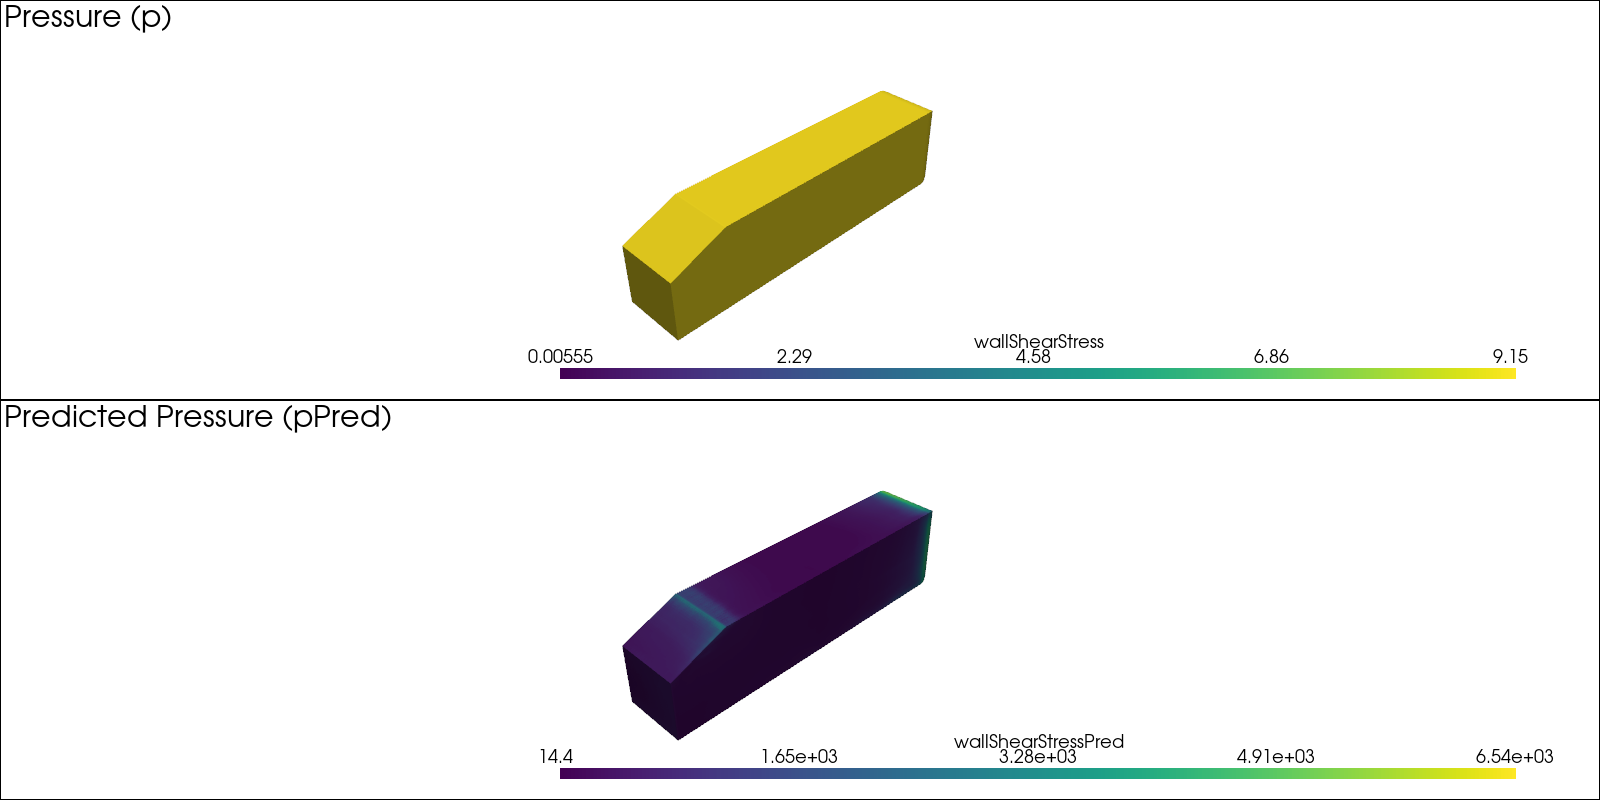

In [56]:
import pyvista as pv

# Start virtual framebuffer for off-screen rendering (useful in Jupyter/containers)
pv.start_xvfb()

# Read the VTP mesh
mesh = pv.read(
    "./ahmed_body_dataset/mesh_predictions_surf_final1/boundary_281_predicted.vtp"
)
print("Available cell data keys:", mesh.cell_data.keys())

# Create a Plotter with 2 vertical subplots
plotter = pv.Plotter(shape=(2, 1), window_size=[1600, 800], off_screen=True)

# Plot 'p' (ground truth or reference)
plotter.subplot(0, 0)
plotter.add_text("Pressure (p)", font_size=12)
plotter.add_mesh(mesh, scalars="p", show_edges=False)

# Plot 'pPred' (predicted pressure)
plotter.subplot(1, 0)
plotter.add_text("Predicted Pressure (pPred)", font_size=12)
plotter.add_mesh(mesh, scalars="pPred", show_edges=False)

# Show both subplots
plotter.show(jupyter_backend="static")

In [ ]:
import os

os._exit(00)